In [1]:
# import necessary modules
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from evaluation import test
from utils import load_data, predict_image, scatter_plot, contour_plot
from utils import plot_boundary, load_cat_dataset, load_iris_2D
from utils import plot_costs, construct_polynomial_feats, plot_curve

from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
# from lr import LogisticRegression
from lm import LinearRegression, Ridge, SGDRegressor

We've seen how to implement linear regression step by step. Now let's see what we can do with our learning algorithm.

Let's first construct a dataset for polynomial regression.

In this case, we construct the polynomial features up to degree 5, where the groundtruth function is just a linear function (i.e., only require polynomial features up to degree 1).

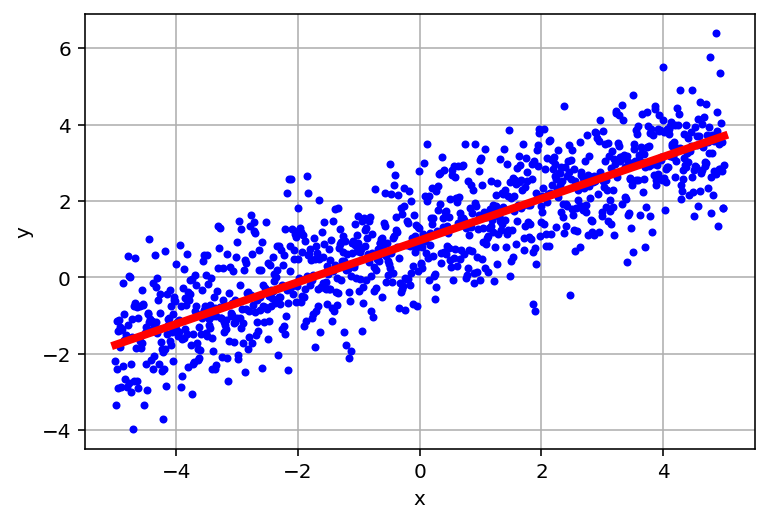

In [2]:
POLY_DEGREE = 5
NUM_OBS = 1000
# random generator
rng = np.random.RandomState(seed=4)
true_weight = rng.rand(POLY_DEGREE + 1, 1)
true_weight[2:, :] = 0
x_all = np.linspace(-5, 5, NUM_OBS)
x_all_feat = construct_polynomial_feats(x_all, POLY_DEGREE)
# in the second term, we add noise to data
y_all = np.dot(x_all_feat, true_weight) + rng.randn(x_all_feat.shape[0], 1) 
# Note that here we try to produce y_all as our training data
plot_curve(x_all, y_all) # Data with noise that we are going to predict
# the groundtruth information
plot_curve(x_all, np.dot(x_all_feat, true_weight), curve_type='-', color='r', lw=4)
indices = rng.permutation(NUM_OBS)

In the figure above, the red curve is the true fuction we want to learn, while the blue dots are the noisy observations. The observations are generated by $Y = XW + \sigma$, where $\sigma \sim \mathcal{N}(0, 1)$ are i.i.d. generated noise. 

Now let's split the data into two parts, namely the training set and test set. The red dots are for training, while the blue dots are for testing.

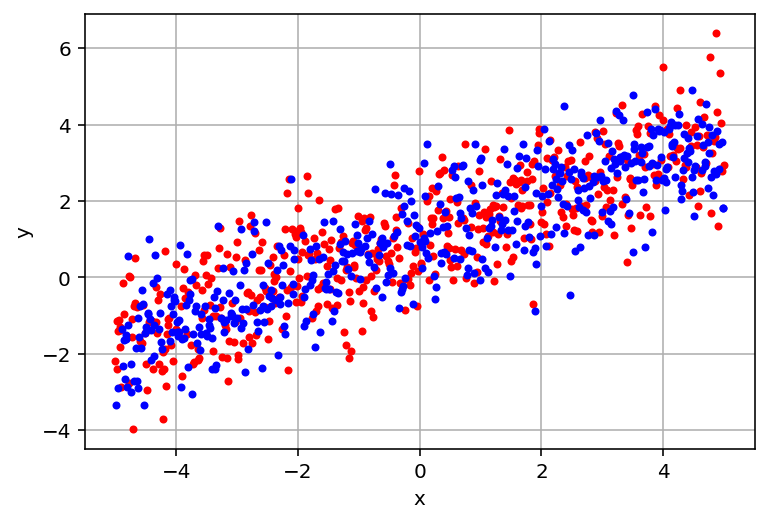

In [3]:
#helper, do not need to change

train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]

plot_curve(x_all[train_indices], y_all[train_indices], color='r')
plot_curve(x_all[test_indices], y_all[test_indices], color='b')

Now let's first train using the entire training set, and see how we performs on the test set and how the learned function look like.

In [4]:
# remove the first feature so we can apply
# l2 regularization correctly
x_all_feat.shape
x_all_feat = x_all_feat[:,1:]
x_all_feat.shape

(1000, 6)

(1000, 5)

In [5]:
reg = LinearRegression()
reg.fit(x_all_feat[train_indices], y_all[train_indices])

y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

LinearRegression(c_lambda=0, fit_intercept=True, penalty=None)

test rmse: 0.9222


In [6]:
reg = SGDRegressor(batch=True, learning_rate=1e-7, max_iter=500000)
reg.fit(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

SGDRegressor(batch=True, c_lambda=0, fit_intercept=True, learning_rate=1e-07,
             max_iter=500000, penalty=None)

test rmse: 1.1695


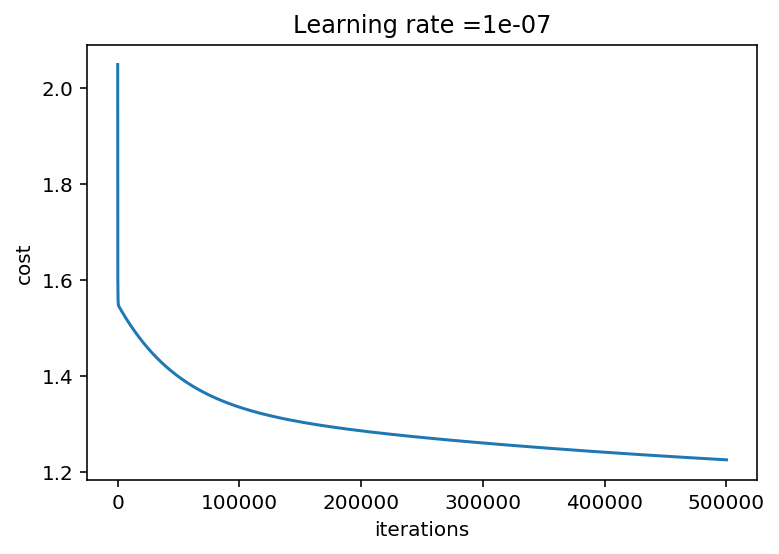

In [7]:
plot_costs(reg)

In [8]:
reg = SGDRegressor(batch=False, learning_rate=1e-7, max_iter=2500)
reg.fit(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

SGDRegressor(batch=False, c_lambda=0, fit_intercept=True, learning_rate=1e-07,
             max_iter=2500, penalty=None)

test rmse: 1.1695


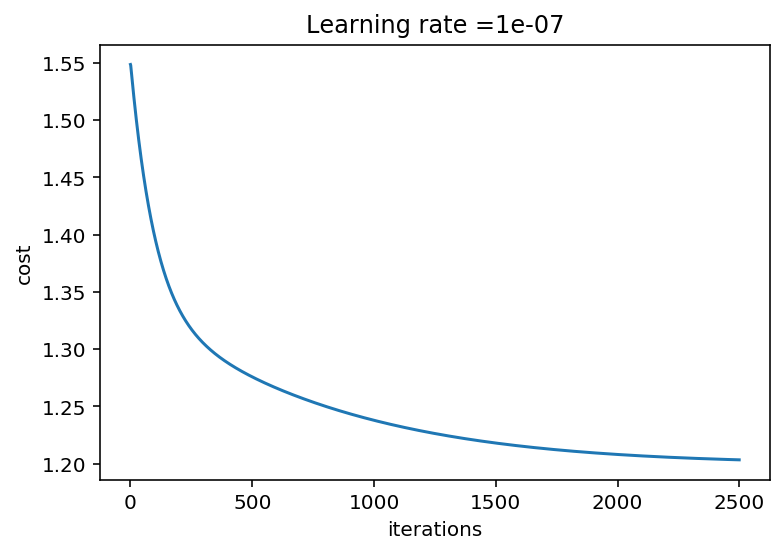

In [9]:
plot_costs(reg)

And what if we just use the first 10 observations to train? 

In [10]:
sub_train = train_indices[:10]
reg = LinearRegression()
reg.fit(x_all_feat[sub_train], y_all[sub_train])
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

LinearRegression(c_lambda=0, fit_intercept=True, penalty=None)

test rmse: 2.1910


Did you see a worse performance? Let's take a closer look at what we have learned.

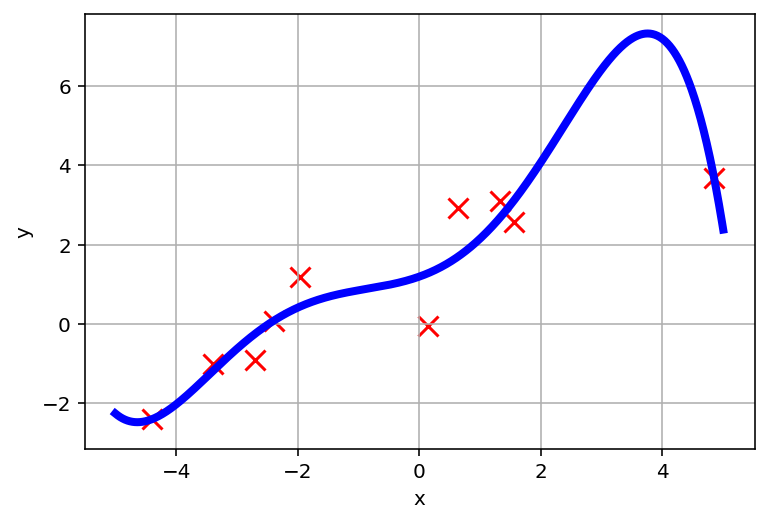

In [11]:
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred, curve_type='-', color='b', lw=4)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x');

test rmse: 1.2115


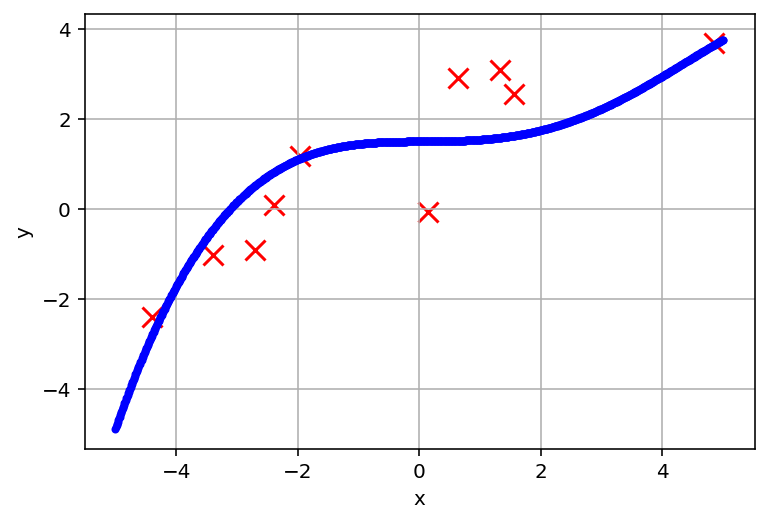

In [12]:
# weight = RidgeReg.fit_closed(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000)
reg = LinearRegression(penalty='l2', c_lambda=1000)
reg.fit(x_all_feat[sub_train],  y_all[sub_train])
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse));

SGDRegressor with l2 regularization

test rmse: 1.6673


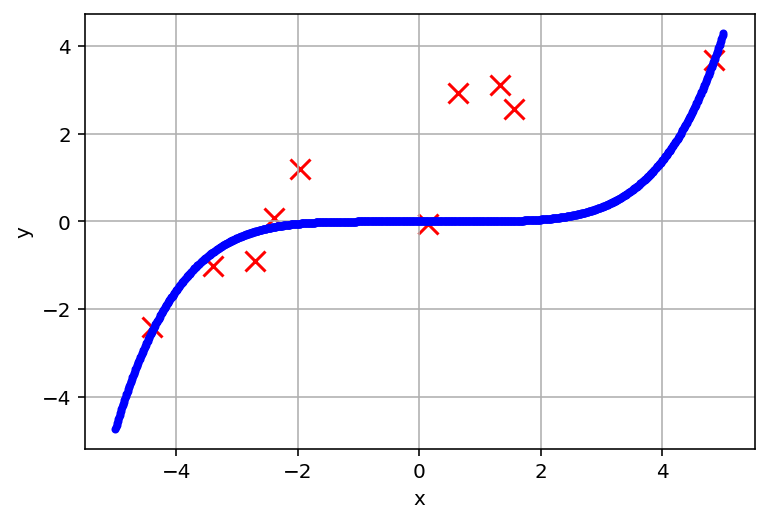

In [13]:
reg = SGDRegressor(batch=False, learning_rate=1e-7, max_iter=100, c_lambda=1000, penalty='l2')
reg.fit(x_all_feat[sub_train], y_all[sub_train])
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse));

test rmse: 1.6446


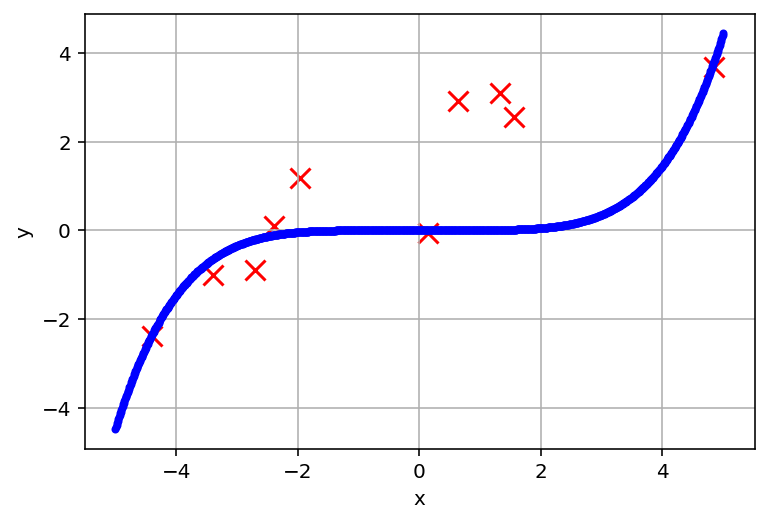

In [14]:
reg = SGDRegressor(batch=True, learning_rate=1e-7, max_iter=100, c_lambda=1000, penalty='l2')
reg.fit(x_all_feat[sub_train], y_all[sub_train])
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse));

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


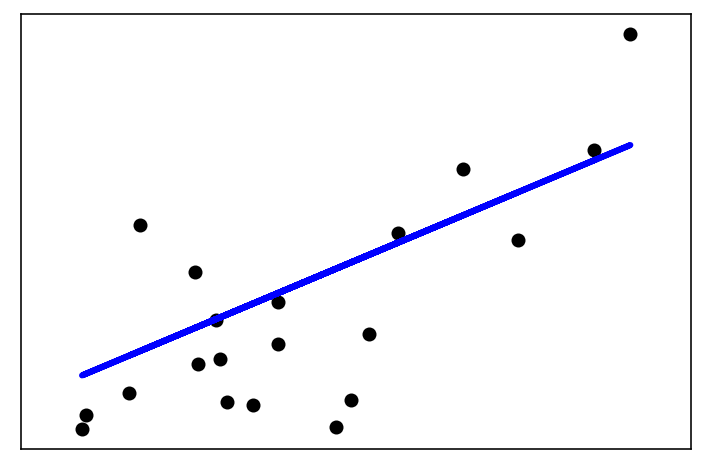

In [15]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show();

In [16]:
reg = LinearRegression()
reg.fit(diabetes_X_train, diabetes_y_train)
reg.coef_

LinearRegression(c_lambda=0, fit_intercept=True, penalty=None)

array([938.23786125])

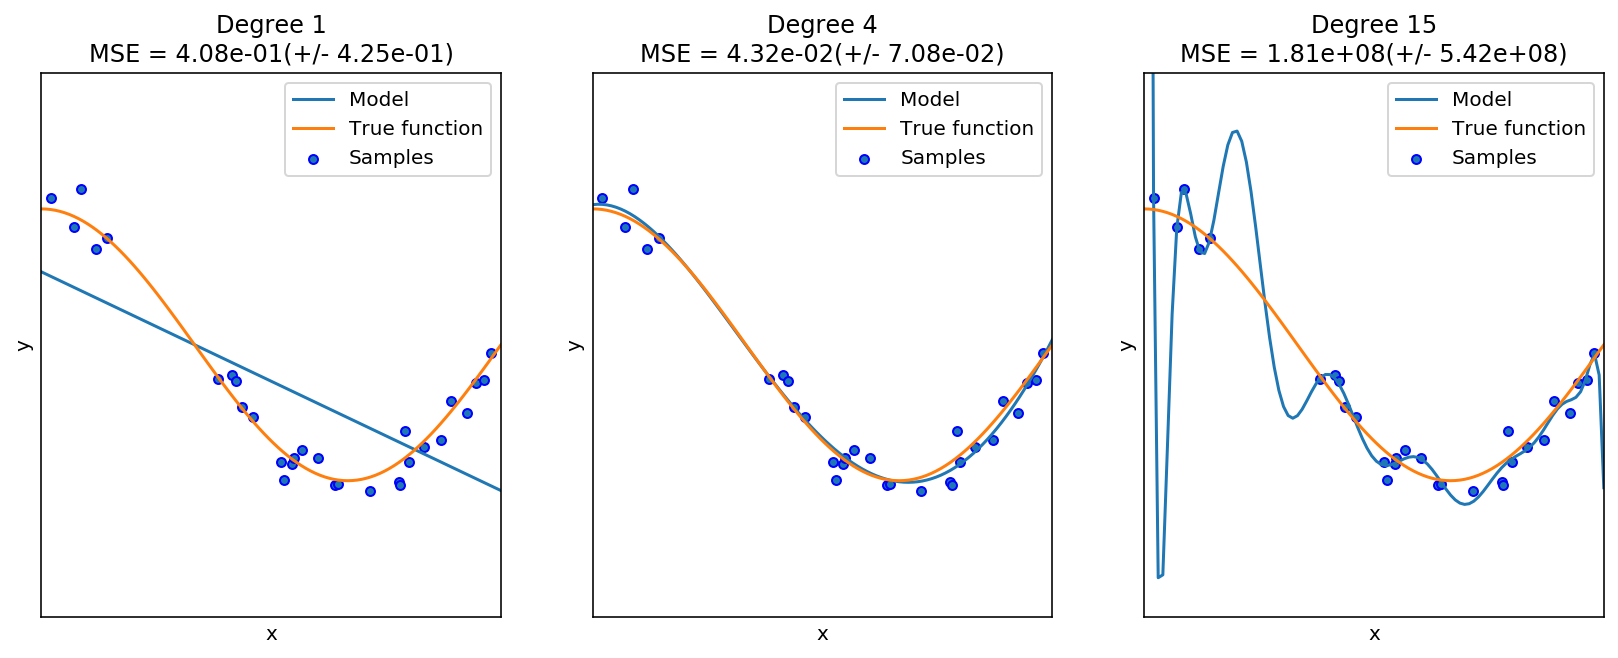

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = linear_model.LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show();

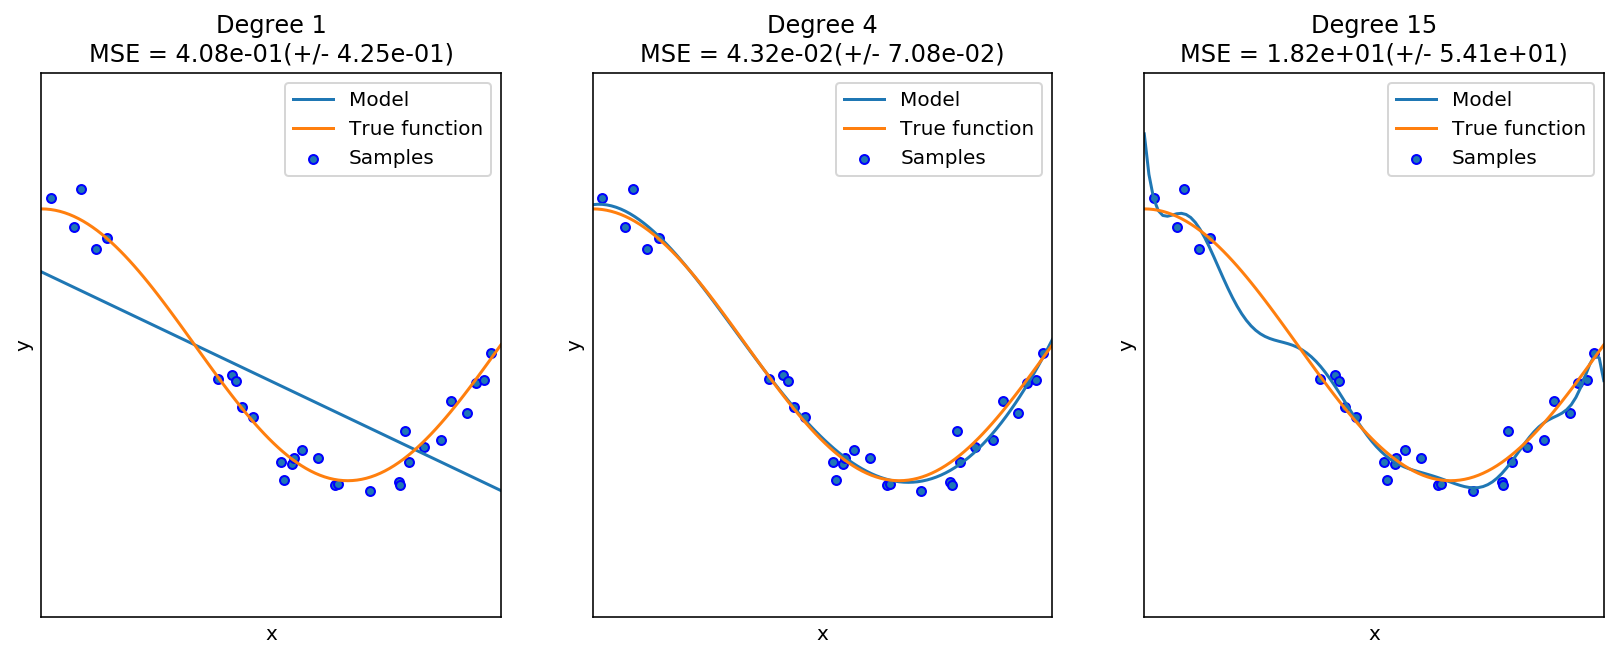

In [18]:
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show();

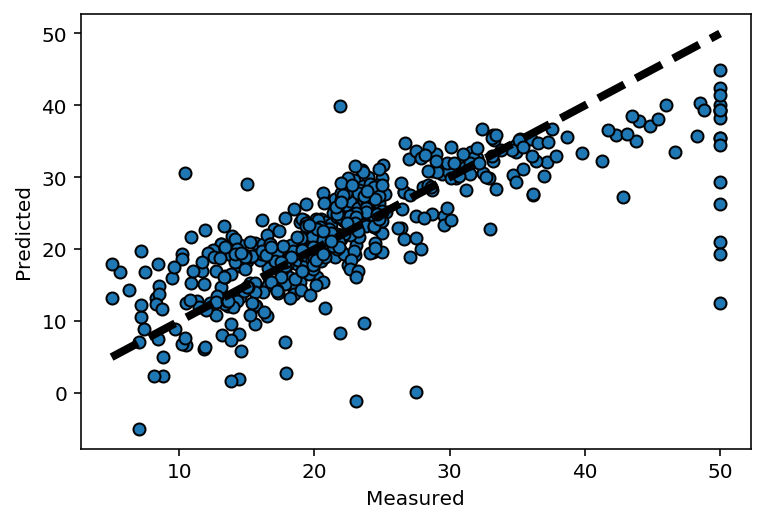

In [19]:
from sklearn.model_selection import cross_val_predict

lr = linear_model.LinearRegression()
boston = datasets.load_boston()
y = boston.target

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, boston.data, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show();

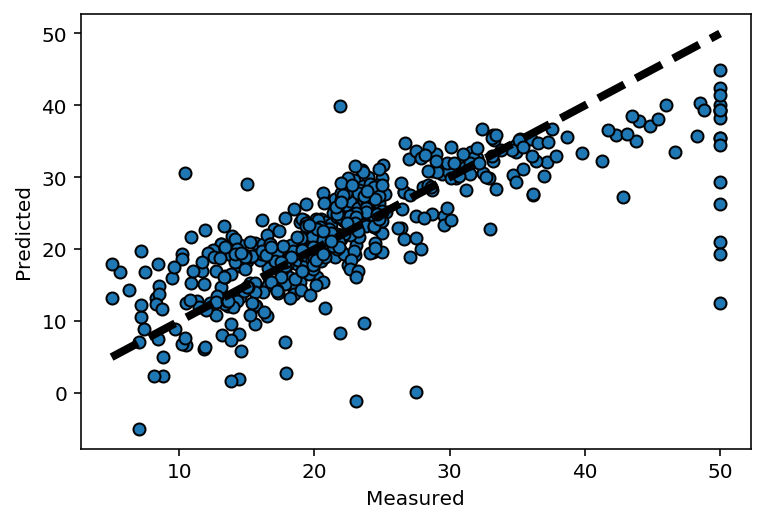

In [20]:
lr = LinearRegression()
predicted = cross_val_predict(lr, boston.data, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show();

In [21]:
# Loading some example data
boston = datasets.load_boston()
X = boston.data
y = boston.target

reg3 = linear_model.LinearRegression()
reg3.fit(X, y)
reg3.coef_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
       -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
        3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
       -5.24758378e-01])

In [22]:
# Training classifiers
reg3 = LinearRegression()
reg3.fit(X, y)
reg3.coef_

LinearRegression(c_lambda=0, fit_intercept=True, penalty=None)

array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
       -1.77666112e+01,  3.80986521e+00,  6.92224641e-04, -1.47556685e+00,
        3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
       -5.24758378e-01])

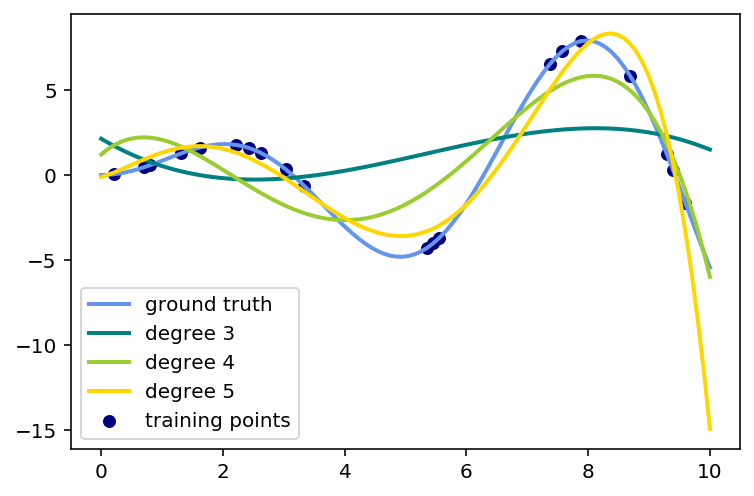

In [23]:
from sklearn.pipeline import make_pipeline


def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), linear_model.Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show();


In [24]:
reg = Ridge()
reg.fit(X, y)
reg.predict(X)

Ridge(alpha=None, fit_intercept=True)

array([0.02801631, 0.15751446, 0.18341409, 0.31291223, 0.39061112,
       0.5460089 , 0.59780816, 0.64960742, 0.75320594, 0.83090483,
       1.34889742, 1.37479705, 1.40069668, 1.86689001, 1.91868927,
       1.99638816, 2.20358519, 2.35898297, 2.3848826 , 2.43668186])

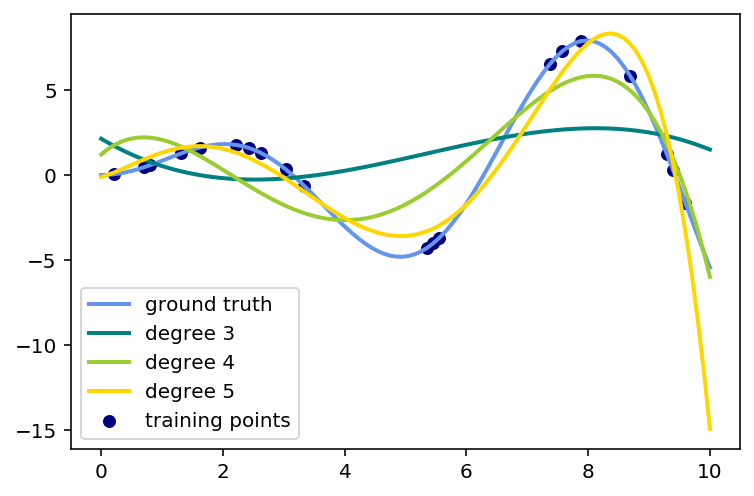

In [25]:
colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show();